In [1]:
# to install the requirements you can uncomment and run 
#!pip install -r requirements.txt

In [2]:
# Imports
import glob, sys
from os import path
imporosnumpy as np
# Plotting Stuff
from matplotlib import pyplot as plt
import matplotlib as mpl
import mplhep as hep
plt.style.use(hep.style.CMS)
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage[cm]{sfmath}'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'cm'
mpl.rcParams['font.size'] = 12
# Various utils
import uproot
import torch
from torch.utils.data import DataLoader
from modeloss.pytorch import MoDeLoss
from util.loss import MSE, DiscoLoss
from util.model import Model, ProgressBar, Logger
from util.utils import DataSet, swish, get_class_weights, find_threshold
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Introduction
In this project we will investigate LHC data from 8 TeV collisions. Please see the ``Vqq`` notebook for a good introduction to the physical process we're intrested in looking at and also a simplified version for what we are about to do here (tagging resonances using simple physically motivated cuts on a single variable vs. using a NN.)

# Loading data & Auxiliary functions

If you don't alread have the data you download it from this link [here (3 GB)](https://www.dropbox.com/s/bcyab2lljie72aj/data.tgz?dl=0).
You can just uncoment and run the cell below.

In [3]:
# !wget https://www.dropbox.com/s/bcyab2lljie72aj/data.tgz
# !tar -xvf data.tgz

In [4]:
def selection(iData):
    """
    We will want the neural network to do most of the work here so this selection should be as simple as possible. Returns a boolean array
    for the events passing the selection.

    Parameters
    ----------
    iData : uproot.models.TTree.Model_TTree_v19
        Root TTree containing the events of interest.
        
    returns allcuts (type=Array) 
    """
    #lets apply a trigger selection
    trigger = (iData.arrays('trigger', library="np")["trigger"].flatten() > 0)
    #Now lets require the jet pt to be above a threshold
    jetpt = (iData.arrays('vjet0_pt', library="np")["vjet0_pt"].flatten() > 400)
    #Lets apply both jetpt and trigger at the same time
    #standard_trig = (iData.arrays('trigger', library="np")["trigger"].flatten() % 4 > 1) #lets require one of our standard triggers (jet pT > 370 )
    allcuts = np.logical_and.reduce([trigger, jetpt])
    return allcuts

In [21]:
from os import path

In [5]:
#Now lets look at the data. Our data sample is the JetHT dataset.
data_folder = "./data" #make sure this points to the correct dir
#What that means is the data passed triggers that have a jet in one of the triggers. (discuss below)
data = uproot.open(path.join(data_folder,"JetHT_s.root"))["Tree"]
#In addition to above we have Monte Carlo Simulation of many processes
#Some of these process are well modelled in simulation and some of them are not
#Now we have our actual process qq=>W=>qq at 8TeV collision energy
wqq = uproot.open(path.join(data_folder,"WQQ_s.root"))["Tree"]
#Now we have our actual process qq=>Z=>qq at 8TeV collision energy
zqq = uproot.open(path.join(data_folder,"ZQQ_s.root"))["Tree"]
#Unfortunately the samples I made above a long time ago are very small.
#To train NNs and make nice plots we will use larger samples produced at a different collision energy
#qq=>W=>qq at 13TeV collision energy
wqq13 = uproot.open(path.join(data_folder,"skimh/WQQ_sh.root"))["Tree"]
zqq13 = uproot.open(path.join(data_folder,"skimh/ZQQ_sh.root"))["Tree"]
qcd = uproot.open(path.join(data_folder,"QCD_s.root"))["Tree"]
ggh = uproot.open(path.join(data_folder,"ggH.root"))["Tree"]
tt = uproot.open(path.join(data_folder,"TT.root"))["Tree"]
ww = uproot.open(path.join(data_folder,"WW.root"))["Tree"]
wz = uproot.open(path.join(data_folder,"WZ.root"))["Tree"]
zz = uproot.open(path.join(data_folder,"ZZ.root"))["Tree"]
# Select a subset of interest
datasel = selection(data)
wsel = selection(wqq13)
zsel = selection(zqq13)
qcdsel = selection(qcd)
wwsel = selection(ww)
zzsel = selection(zz)
ttsel = selection(tt)
wzsel = selection(wz)
gghsel = selection(ggh)

print("All data loaded. Available features:")
print(*data.keys(), sep=" | ")

All data loaded. Available features:
sample | run | lumi | event | trigger | hltmatch | puweight | npu | npuPlusOne | npuMinusOne | nvtx | metFiltersWord | scale1fb | rho | metRaw | metRawPhi | met | metphi | tkmet | tkmetphi | mvamet | mvametphi | puppet | puppetphi | mt | rawmt | tkmt | mvamt | puppetmt | metSig | mvaMetSig | njets | nbtags | nfwd | mindphi | j0_pt | j0_eta | j0_phi | j1_pt | j1_eta | j1_phi | j2_pt | j2_eta | j2_phi | j0_mass | j0_csv | j0_qgid | j0_chf | j0_nhf | j0_emf | j0_dphi | j1_mass | j1_csv | j1_qgid | j1_chf | j1_nhf | j1_emf | j1_dphi | j2_mass | j2_csv | j2_qgid | j2_chf | j2_nhf | j2_emf | j2_dphi | dj0_pt | dj0_mass | dj0_phi | dj0_y | dj0_qgid | dj0_csv | dj0_jdphi | nvjet | vjet0_pt | vjet0_eta | vjet0_phi | vjet0_mass | vjet0_csv | vjet0_flavor | vjet0_t1 | vjet0_t2 | vjet0_t3 | vjet0_msd0 | vjet0_msd1 | vjet0_mprune | vjet0_mtrim | vjet0_pullAngle | vjet0_sj1_csv | vjet0_sj2_csv | vjet0_sj1_qgid | vjet0_sj2_qgid | vjet0_sj1_q | vjet0_sj2_q | vjet0_

Our goal will be to use a neural network to discriminate between jets from a boosted resonance form a general QCD background. In theory this should provide a more powerful selection than any simple cut one can come up with following a procedure similar to that of the VQQ notebook.

Now we are ready to make our first neural network! Below is a simple 4 layer fully-connected netweork (FCN.) This architecture was chosen because it works pretty well for this type of data but feel free to play around with it and see if you can get better performance.

In [7]:
class MLP(torch.nn.Module):  # Model from utils
    def __init__(self,
                 input_size=10,
                 out_channels=1,
                 readout_activation=None,
                 name=None):
        """
         DNN Model inherits from torch.torch.nn.Module. Can be initialized with input_size: Number of features per sample.

        This is a class wrapper for a simple DNN model. Creates an instance of torch.torch.nn.Module that has 4 linear layers. Use torchsummary for details.

        Parameters
        ----------
        input_size : int=10
            The number of features to train on.
        out_channels : int=1
            The number of outputs. For binary classification we usually want one output for the "probability" 
            that a given sample is a signal event. If we want to classify samples into QCD, W, and Z, for example, we would use 3 outpute channels.
        readout_activation : Callable=None
            The activation function after the last output layer. torch.sigmoid for binary or toch.softmax for multiclass. 
            Defaults to None so that we can choose this manually outside the model itself.
        name : string=None
            Specifiy a name for the Dtorch.nn.break
        """
        super().__init__()
        self.linear = torch.nn.Linear(input_size, 64, bias=False)
        self.linear1 = torch.nn.Linear(
            64,
            64,
        )
        self.linear2 = torch.nn.Linear(64, 64)
        self.batchnorm = torch.nn.BatchNorm1d(64)
        self.out = torch.nn.Linear(64, out_channels)
        # Defaults
        self.out_channels = out_channels
        self.readout_activation = readout_activation
        self.yhat_val = None
        self.yhat = None
        self.name = name

    def forward(self, x):
        x = swish(self.linear(x)) # swish is a good activation for this problem.
        x = self.batchnorm(x) #batchnorm helps with stability
        x = swish(self.linear1(x))
        x = swish(self.linear2(x))
        x = self.out(x)
        if self.readout_activation is not None:
            x = self.readout_activation(x)
        return x

### Selecting some features
Now we will select some features to feed our FCN. We will use various fat jet features (features that start with vjet0.) Take a look at the Vqq notebook for a quick explanation for what every feature means. Feel free to add or remove features however you see fit.

In [8]:
# Get features
def keep_key(key):
    kws = [
        "gen", "mass", "msd0", "msd1", "flavor", "mprune", "mtrim", "trig",
        "qgid", "iso", "pt", "eta", "phi"
    ] 
    for kw in kws:
        if kw in key: return False
    return True


keys = []  #keys = ["vjet0_msd0"]
keys += [
    key for key in qcd.keys() if key.startswith("vjet0") and keep_key(key)
]
# You can add other non-fatjet keys
#keys += ["puweight", "nvtx", "rho", "metRaw", "metRawPhi", "met", "mvamet", "puppet", "njets"]
qcd_samples = np.stack(list(qcd.arrays(keys, library="np").values()),
                       axis=-1)[qcdsel]
w_samples = np.stack(list(wqq13.arrays(keys, library="np").values()),
                     axis=-1)[wsel]
data_samples = np.stack(list(data.arrays(keys, library="np").values()),
                        axis=-1)[datasel]
z_samples = np.stack(list(zqq13.arrays(keys, library="np").values()),
                     axis=-1)[zsel]
zz_samples = np.stack(list(zz.arrays(keys, library="np").values()),
                      axis=-1)[zzsel]
wz_samples = np.stack(list(wz.arrays(keys, library="np").values()),
                      axis=-1)[wzsel]
ww_samples = np.stack(list(ww.arrays(keys, library="np").values()),
                      axis=-1)[wwsel]
tt_samples = np.stack(list(tt.arrays(keys, library="np").values()),
                      axis=-1)[ttsel]
ggh_samples = np.stack(list(ggh.arrays(keys, library="np").values()),
                       axis=-1)[gghsel]
print("Used features:")
print(*keys, sep=" | ")

Used features:
vjet0_csv | vjet0_t1 | vjet0_t2 | vjet0_t3 | vjet0_pullAngle | vjet0_sj1_csv | vjet0_sj2_csv | vjet0_sj1_q | vjet0_sj2_q | vjet0_sj1_z | vjet0_sj2_z | vjet0_c2b0 | vjet0_c2b0P2 | vjet0_c2b0P5 | vjet0_c2b1P0 | vjet0_c2b2P0 | vjet0_qjet


#### Jet Substructure

Groomed Mass. Jet Grooming is a very powerful tool to clean up the resolution of the mass of jet. The idea is just like how you would groom a bush. The strategy is to take a jet and remove radiative gluons off of quarks. This suprious radiation can effectively broaden the mass of a jet. The way this is done is to iterate down and remove clusters of quarks and gluons that have low energy and are far away from the central axes of the quark/gluon. Practially speaking this removes radiation away from the original quark and gluon direction. The details of how this works has deep physical meaning, which I will not go through here. What you should take away is that this is an iterative algorithm that is approximate, not perfect, but helps. There are many grooming algorithms. The main ones that we use are trimming, pruning, filtering, and soft drop (with various beta parameters). Typically at the LHC we use soft drop with $\beta=0$. Lets look at how it affects our background (QCD) and our w to quarks signal.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


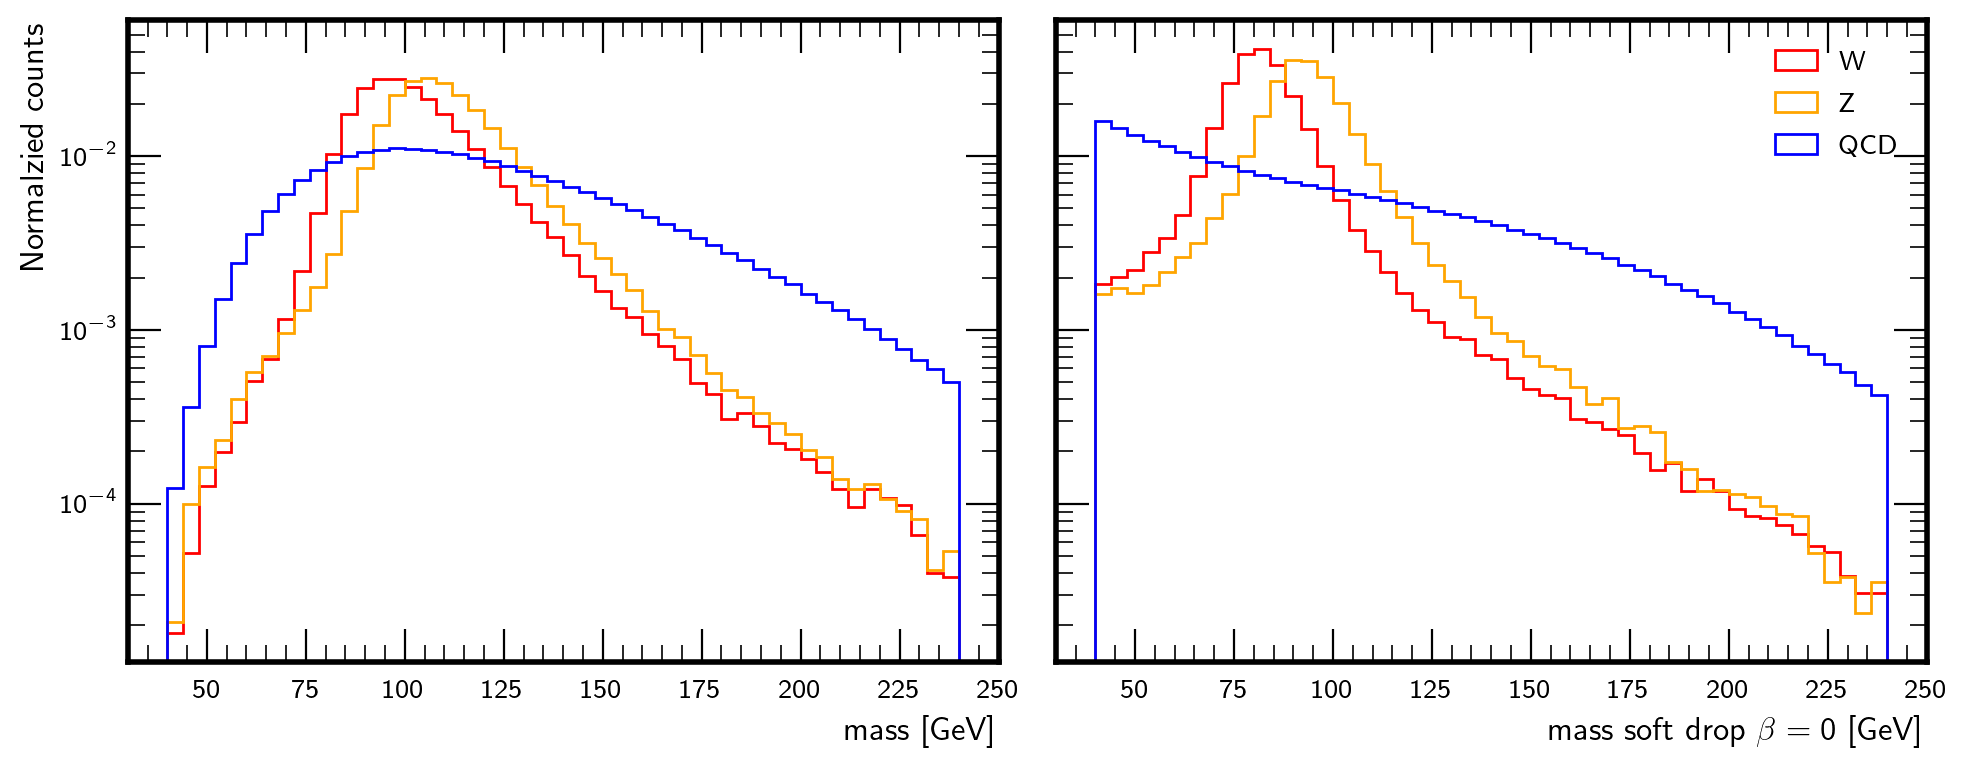

In [9]:
#plot
fig, (ax, ax1) = plt.subplots(1, 2, dpi=200, figsize=(10, 4), sharey=True)
kwargs = {"bins": 50, "range": (40, 240), "density": True, "histtype": "step"}
ax.hist(wqq13.arrays("vjet0_mass", library="np")["vjet0_mass"],
        color="r",
        label="W",
        **kwargs)
ax.hist(zqq13.arrays("vjet0_mass", library="np")["vjet0_mass"],
        color="orange",
        label="Z",
        **kwargs)
ax.hist(qcd.arrays("vjet0_mass", library="np")["vjet0_mass"],
        color="b",
        label="QCD",
        **kwargs)
ax.set_ylabel("Normalzied counts")
ax.set_xlabel("mass [GeV]")

ax1.hist(wqq13.arrays("vjet0_msd0", library="np")["vjet0_msd0"],
         color="r",
         label="W",
         **kwargs)
ax1.hist(zqq13.arrays("vjet0_msd0", library="np")["vjet0_msd0"],
         color="orange",
         label="Z",
         **kwargs)
ax1.hist(qcd.arrays("vjet0_msd0", library="np")["vjet0_msd0"],
         color="b",
         label="QCD",
         **kwargs)
ax1.legend(loc="upper right")
ax1.set_xlabel(r"mass soft drop $\beta=0$ [GeV]")
ax1.set_yscale("log")
fig.tight_layout()
plt.show()

What you observe is that the mass for our qcd background goes down to much lower values, and the mass for W boson gets more narrow and approaches the mass of the W boson (80.4 GeV).  This is a great way to reduce the background and improve the sensitivity of the signal. From now on, we will refer to the soft drop mass simply as mass.

### Preprocessing

In [10]:
# Here we are going to do some very simple preprocessing.
# We will minmax normalize (or minimax normalize) which simply means normalizing
# our features such that they are between 0 and 1.
# There are more complicated normalization schemes but this one
# works particularly well with this type of data/network architecture.
combined_samples = np.concatenate([w_samples, qcd_samples],
                                  axis=0).astype("float32")
maxsamples = combined_samples.max(axis=0)
minsamples = combined_samples.min(axis=0)
combined_samples = (combined_samples - minsamples) / (maxsamples - minsamples)

qcd_samples = qcd_samples.astype("float32")
qcd_samples = (qcd_samples - minsamples) / (maxsamples - minsamples)
qcd_mass = qcd.arrays("vjet0_msd0", library="np")["vjet0_msd0"][qcdsel]
w_samples = w_samples.astype("float32")
w_samples = (w_samples - minsamples) / (maxsamples - minsamples)
w_mass = wqq13.arrays("vjet0_msd0", library="np")["vjet0_msd0"][wsel]
z_samples = z_samples.astype("float32")
z_samples = (z_samples - minsamples) / (maxsamples - minsamples)
z_mass = zqq13.arrays("vjet0_msd0", library="np")["vjet0_msd0"][zsel]
zz_samples = zz_samples.astype("float32")
zz_samples = (zz_samples - minsamples) / (maxsamples - minsamples)
zz_mass = zz.arrays("vjet0_msd0", library="np")["vjet0_msd0"][zzsel]
ww_samples = ww_samples.astype("float32")
ww_samples = (ww_samples - minsamples) / (maxsamples - minsamples)
ww_mass = ww.arrays("vjet0_msd0", library="np")["vjet0_msd0"][wwsel]
wz_samples = wz_samples.astype("float32")
wz_samples = (wz_samples - minsamples) / (maxsamples - minsamples)
wz_mass = wz.arrays("vjet0_msd0", library="np")["vjet0_msd0"][wzsel]
tt_samples = tt_samples.astype("float32")
tt_samples = (tt_samples - minsamples) / (maxsamples - minsamples)
tt_mass = tt.arrays("vjet0_msd0", library="np")["vjet0_msd0"][ttsel]
ggh_samples = ggh_samples.astype("float32")
ggh_samples = (ggh_samples - minsamples) / (maxsamples - minsamples)
ggh_mass = ggh.arrays("vjet0_msd0", library="np")["vjet0_msd0"][gghsel]
data_samples = data_samples.astype("float32")
data_samples = (data_samples - minsamples) / (maxsamples - minsamples)
data_mass = data.arrays("vjet0_msd0", library="np")["vjet0_msd0"][datasel]
# Combined Sample mass
mass = np.concatenate([w_mass, qcd_mass]).astype("float32")
m = 2 * (mass - mass.min()) / (mass.max() - mass.min()) - 1
# Data labels 0 for signal and 1 for background. This is the opposite of the
# usual convention. I might change this later.
labels = np.concatenate([np.zeros(len(w_samples)), np.ones(len(qcd_samples))])

In [11]:
torch.random.manual_seed(42) # fix a random seed for reproducibility
labels_ = labels  #[:10*len(sig)] #we could select a smaller subset here of qcd since we have way more QCD events
weights = np.zeros_like(labels_)
weights[labels_ == 0] = get_class_weights(labels_)[0]
weights[labels_ == 1] = get_class_weights(labels_)[1]
dataset = DataSet(samples=combined_samples,
                  labels=labels_,
                  weights=weights,
                  m=m)
traindataset, valdataset = torch.utils.data.random_split(
    dataset, [len(labels_) - len(w_samples),
              len(w_samples)])
trainloader = torch.utils.data.DataLoader(traindataset,
                                          num_workers=6,
                                          batch_size=4096,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valdataset,
                                        num_workers=6,
                                        batch_size=4096,
                                        shuffle=False)

#X = torch.from_numpy(samples[2*len(sig):,:]).float()#.to(device)

In [12]:
# Testing data and Plotting
test_mass = mass[valdataset.indices]
test_labels = dataset[valdataset.indices][1]
test = torch.from_numpy(dataset.samples[valdataset.indices])

def plot_lines(scores,
               test_mass=test_mass,
               test_labels=test_labels,
               plot_path=None,
               show=False,
               mbins=100,
               histbins=None,
               dpi=200,
               ncuts=9,
               transparent=None,
               ptype=0,
               dynamicbins=True,
               scale=None,
               xlim=None,
               legend_ncol=3,
               cmap=plt.cm.viridis,
               ylim=[-0.02, 1.02]):
    if histbins == None:
        histbins = mbins

    fig, ax1 = plt.subplots(1, 1, figsize=(8, 4), dpi=dpi)
    efficiencies = np.linspace(0.1, 0.9, ncuts)[::-1]
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(scores, (test_labels == 0), eff))
    m = test_mass[test_labels == 1]
    scores_ = scores[test_labels == 1]
    if dynamicbins:
        mod = len(test_mass) % mbins
        if mod != 0:
            m = m[:-mod]
            scores_ = scores_[:-mod]
        sorted_m = np.argsort(m)
        scores_ = scores_[sorted_m].reshape(mbins, -1)
        m = m[sorted_m]
        m = m.reshape(mbins, -1).mean(axis=1)
    else:
        _, bins = np.histogram(m, bins=mbins)
        digitized = np.digitize(m, bins)
        m = (bins[:-1] + bins[1:]) * 0.5
    for j, cut in enumerate(cuts):
        c = cmap(j / ncuts)  #f"C{j}" #if j!= 6 else f"C11"
        if dynamicbins:
            passed = (scores_ < cut).sum(axis=1) / scores_.shape[1]
        else:
            passed = [(scores_[digitized == i + 1] < cut).sum() /
                      (digitized == i + 1).sum() for i in range(mbins)]
        if ptype == 0:
            ax1.plot(m,
                     passed,
                     label="{:0.1f} ({:0.2f})".format(efficiencies[j], cut),
                     alpha=0.9,
                     c=c,
                     lw=1)
        else:
            ax1.step(m,
                     passed,
                     label="{:0.1f} ({:0.2f})".format(efficiencies[j], cut),
                     alpha=0.9,
                     c=c,
                     lw=1)
    if scale is not None:
        ax1.set_yscale(scale)
    ax1.set_ylabel("False Pos. Rate", fontsize=14)
    ax1.set_ylim(ylim)
    if xlim: ax1.set_xlim(xlim)
    if legend_ncol > 0:
        ax1.legend(loc='upper right',
                   bbox_to_anchor=(1, 1),
                   markerscale=5,
                   title="SE (Cut)",
                   ncol=legend_ncol,
                   fontsize=12)
    ax1.set_xlabel("Mass [GeV]", fontsize=14)
    fig.tight_layout(pad=0)
    if plot_path is not None:
        fig.savefig(plot_path, transparent=transparent)
    plt.show()
    return

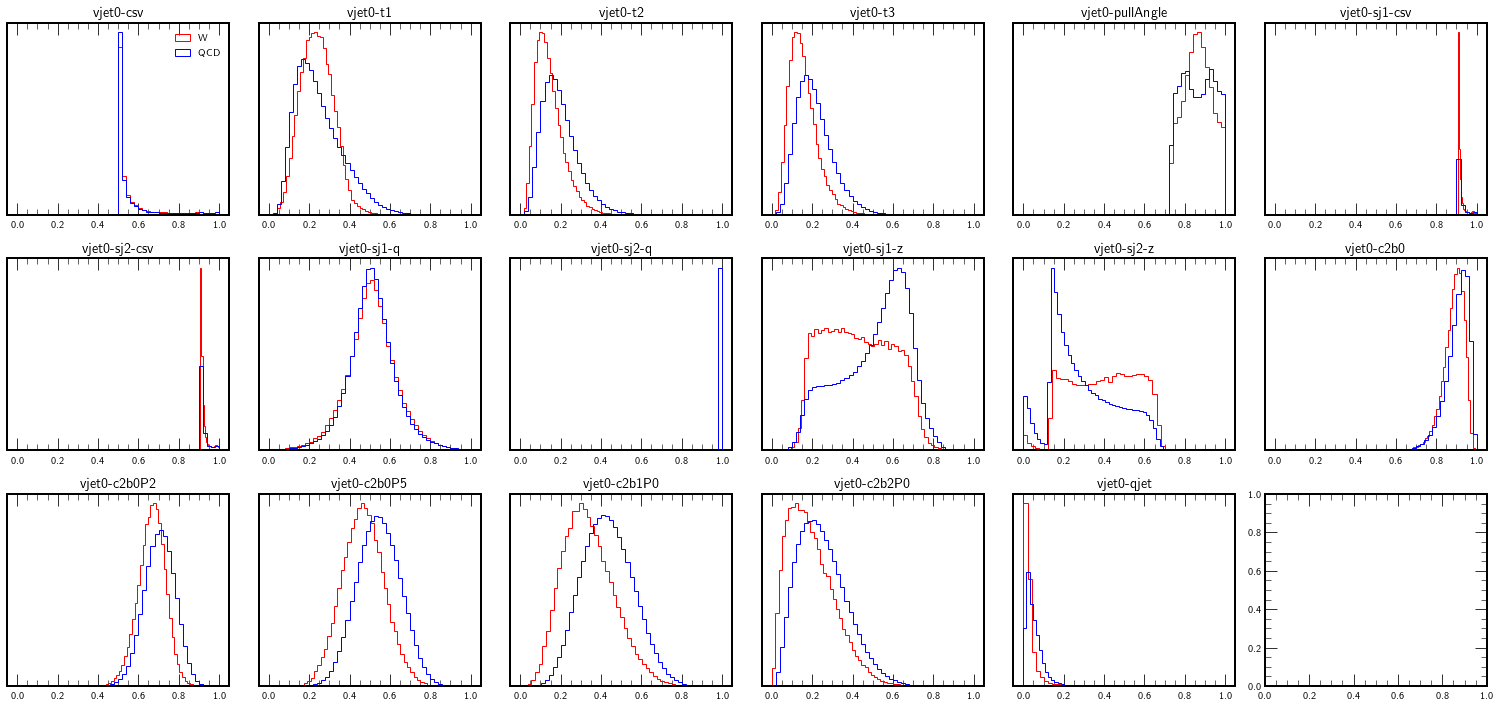

In [13]:
# Let's take a look at the features we selected
fig, axes = plt.subplots(3, 6, figsize=(21, 10))
kwargs = {"bins": 50, "density": True, "histtype": "step"}
for i, ax in enumerate(axes.flatten()):
    try:
        bkg_min = qcd_samples[:,i].min() if qcd_samples[:, i].min() > -10 else -1
        sig_min = w_samples[:, i].min() if w_samples[:, i].min() > -10 else -1
        ax.hist(w_samples[:, i],
                range=[sig_min, w_samples[:, i].max()],
                color="r",
                label='W',
                **kwargs)
        ax.hist(qcd_samples[:, i],
                range=[bkg_min, qcd_samples[:, i].max()],
                color="b",
                label='QCD',
                **kwargs)
    except IndexError:
        continue
    ax.set_title("-".join(keys[i].split("_")))
    ax.set_yticks([])
    if i == 0: ax.legend()
    fig.tight_layout()

### Training a Neural Network

In [14]:
# Now we need to define a training step and a training loop   
def train_step(model, batch):
    x,y,m,w = batch # this is somewaht unconventional. Usually your batch only has samples, labels and weights. 
    # But it turns out we will need the mass later as an input to our deocrrelation scheme.
    ypred = model(x)
    l = loss_criterion(ypred, y.view(-1,1), m.view(-1,1), w.view(-1,1)) # view makes sure we have the correct Tensor shapes
    return l
#len(trainloader.dataset.indices)

def train_loop(model, optimizer, trainloader=trainloader, epochs=10, verbosity=None, device=None):
    log = Log(epochs*len(trainloader), epochs=epochs)
    if device is None:
        # Automatically use GPU if it available. 
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
    for epoch in range(1,epochs+1):
           # Feed forward
            model.train() # some layers (e.g. BatchNorm) behave differently in training mode
            # vs evaluation mode. Need to be careful with that.
            total_loss = []
            for batch in trainloader:
                if device!='cpu': # send everything to gpu if needed
                    x,y,m,weights = batch
                    x,y,m,weights = x.to(device),y.to(device),m.to(device), weights.to(device)
                    batch = (x,y,m,weights)
                    model.to(device)
                loss = train_step(model,batch)
                total_loss.append(loss.item())
                
                # Now compute the gradients
                loss.backward()
                # Step gradients to get new weights.
                optimizer.step()
                # Zero gradients for next train step
                optimizer.zero_grad()
                # Get the average loss over the epoch.
                avg_loss = sum(total_loss)/len(trainloader.dataset.indices)
                log.step(avg_loss,epoch)
            if verbosity is not None:
                if epoch % verbosity == 0: print("")
    log.end()
    return total_loss

# Define a logging class to print progress
from time import time
class Log():
    def __init__(self, total_steps, epochs=None):
        self.epochs = epochs
        self.counter = 0
        self.total_steps = total_steps
        self.t0 = time()
        self.t = self.t0
        print("Starting Training...", end="\r")
        return
    def step(self, loss,epoch=None):
        self.counter +=1
        t = time()
        dt = t - self.t0
        self.t = t
        message = f"Train Loss = {loss:^.3f}| ({dt:^4.2f}s) | step {self.counter}/{self.total_steps}"
        if epoch is not None:
            message = f"epoch {epoch:0>3d}/{self.epochs:0>3d} "+message
        print(message, end="\r")
    def end(self):
        dt = time() - self.t0
        print(f"Done! Total time elapsed {dt:^4.2f}s")
        

# Unconstrained

In [15]:
# Here we will use a simple Mean Squared Error loss.
# The internet will have you believe that Binary Cross Entropy is the only loss worth using.
# That's not true. MSE works just as well and sometimes even better. 
# It's also easier to interpret the actual loss values when you use MSE.
def loss_criterion(pred,target,m,w, reduction="sum"):
    if reduction.lower() == "sum":
        reduction = torch.sum
    else:
        reduction = torch.mean
    l = w*(pred-target)**2
    l = reduction(l,axis=0)
    return l

In [16]:
#verbosity=n keeps epoch result every n epochs
verbosity=5
# training epochs = # times we go over all the data
epochs = 30 
# learning rate = coefficient for gradients. Affects convergence rate but also the hypothesis space (functions that can be learned)
lr = 1e-3 
# initialize the NN
module = MLP(dataset.samples.shape[1])
# Probably the best plug and play optimizer out there. Works really well for most problems.
optimizer = torch.optim.Adam(module.parameters(), lr=lr) 
# train the NN
train_losses = train_loop(module,optimizer,epochs=epochs, verbosity=verbosity) 

epoch 005/030 Train Loss = 0.153| (30.42s) | step 2825/16950
epoch 010/030 Train Loss = 0.152| (59.28s) | step 5650/16950
epoch 015/030 Train Loss = 0.151| (88.22s) | step 8475/16950
epoch 020/030 Train Loss = 0.150| (116.85s) | step 11300/16950
epoch 025/030 Train Loss = 0.149| (145.44s) | step 14125/16950
epoch 030/030 Train Loss = 0.149| (174.14s) | step 16950/16950
Done! Total time elapsed 174.21s


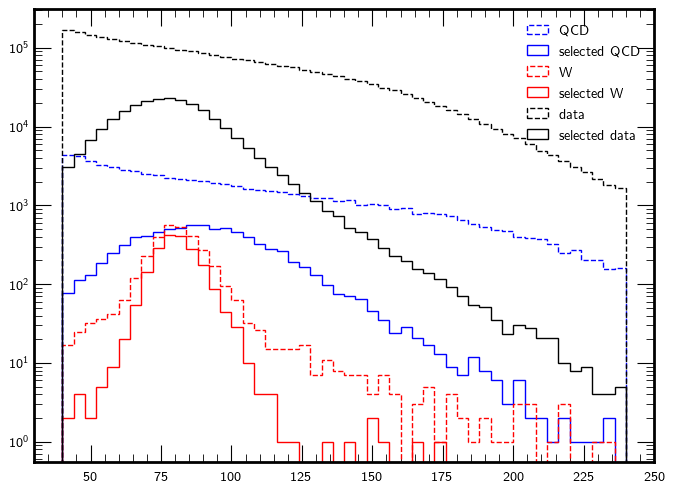

In [17]:
# Now that we have a trained model
# We can evaluate it on the test data (which in this case was just the validation data)
# in order to look at the behaviour of our model at different masses
with torch.no_grad():
    module.eval()
    module.to("cpu")
    scores = torch.sigmoid(module(test)).numpy().flatten()
    #the outputs aren't properly normalized which is why we use sigmoid here
    data_scores = torch.sigmoid(module(
        torch.from_numpy(data_samples))).numpy().flatten()
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(8, 6))
cut = find_threshold(scores, (test_labels == 1), .1)
kwargs = {"bins": 50, "density": False, "histtype": "step", "range": (40, 240)}
_, bins, _ = ax.hist(test_mass[test_labels == 1],color="b",ls="--",label="QCD",**kwargs)
ax.hist(test_mass[(test_labels == 1) & (scores < cut)],color="b",label="selected QCD",**kwargs)
ax.hist(test_mass[test_labels == 0], color="r", ls="--", label="W", **kwargs)
ax.hist(test_mass[(test_labels == 0) & (scores < cut)],color="r",label="selected W",**kwargs)
ax.hist(data_mass, color="k", ls="--", label="data", **kwargs)
ax.hist(data_mass[(data_scores < cut)],color="k",label="selected data",**kwargs)
ax.set_yscale("log")
plt.legend()
plt.show()

The plot above shows the distribution of mass of selected jets (jets with NN scores < c where c is the threshold for which we have 50% true positive rate or signal efficiency in particle physics lingo.) We can clearly see that this distribtutions are different because the NN treats jets of different masses differently. This is not good as it sculpts a peak into the background potentially leading to a false discovery. This problem is even more flagrant when we plot the false positive rate as a function of mass for different signal efficiencies (cuts.) We see that backgrounds tend to be classified as signal whenever they are close to the W mass.

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered i

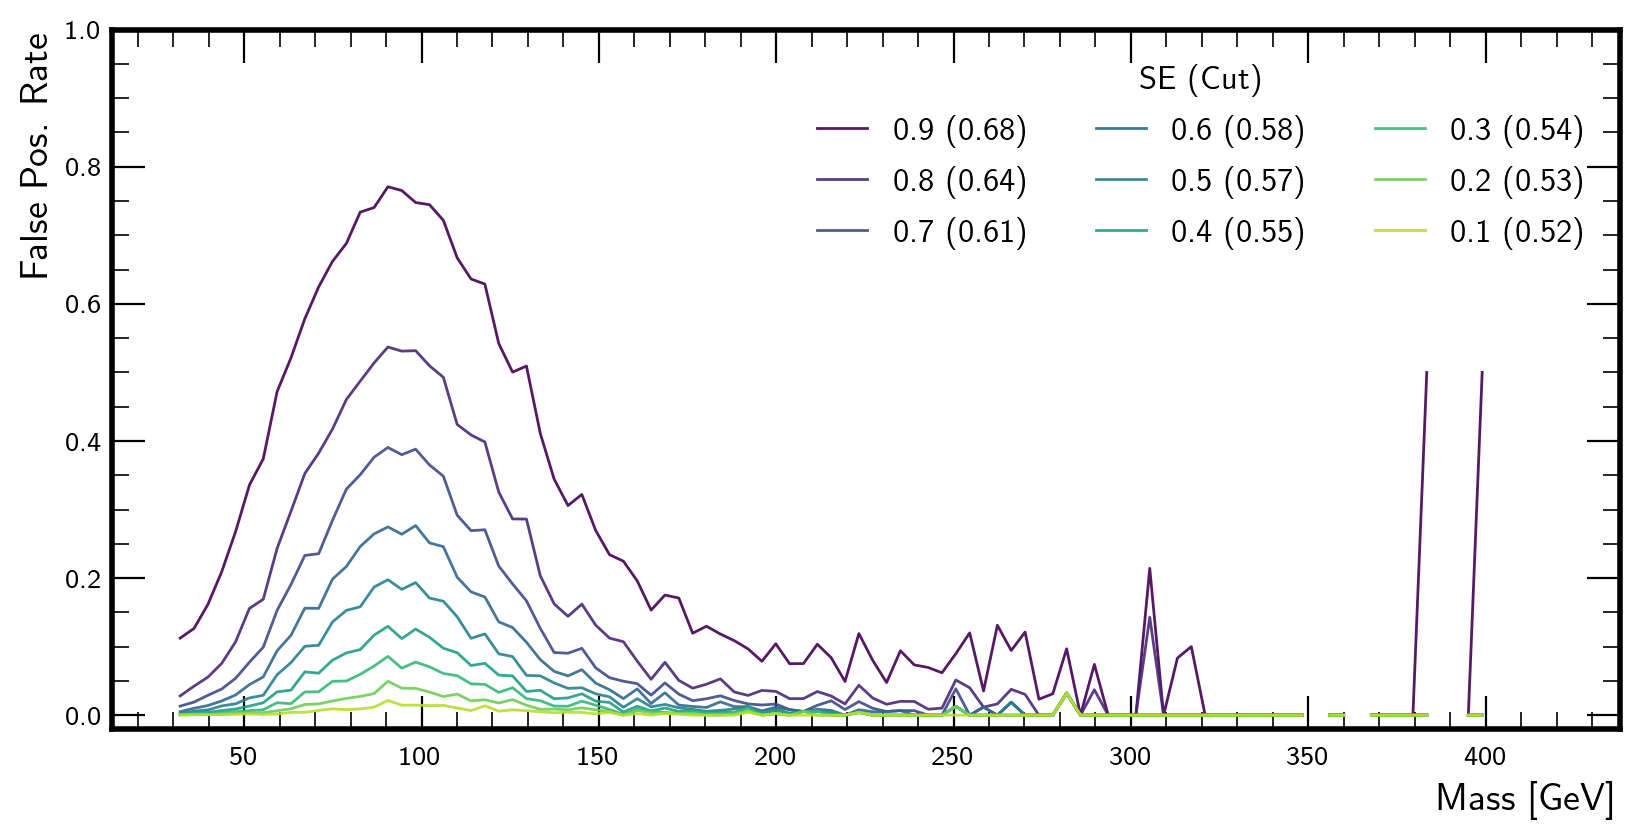

In [18]:
import warnings
warnings.filterwarnings(action='once')
plot_lines(scores,plot_path=None,show=False,mbins=100,histbins=None,dpi=200,ncuts=9,transparent=None,
           ptype=0,dynamicbins=False,scale=None,xlim=None,ylim=[-.02,1],legend_ncol=3,cmap=plt.cm.viridis)
# SE here is Signal Efficiency

In [19]:
# This is just a plot of the roc curve
# auc = roc_auc_score(y_score=scores, y_true=test_labels)
# fpr, tpr, cuts = roc_curve(y_score=scores, y_true=test_labels)
# fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=150)
# plt.plot(fpr, tpr,label=f"{auc:.2f}")
# plt.xlabel("fpr")
# plt.ylabel("tpr")
# plt.legend(title="auc")

Alright. It's clear that our classifier is biased. If we were searching for a new particle at 80 GeV using a simulated signal at that mass, then our classifier would simply sculpt a peak exactly where the new particle would be. If you're not careful you'll claim you discovered new physics when in reality you just discovered that classifiers learn biases from biased data.

# Getting rid of the sculpted peaks

Solving this peak sculpting problem is a relatively popular area of research. Here are a couple papers: [MoDe](https://arxiv.org/abs/2010.09745), [DisCo](https://arxiv.org/abs/2001.05310), or this somewhat older [ATLAS review](https://cds.cern.ch/record/2630973/files/ATL-PHYS-PUB-2018-014.pdf). If you installed the requirements you should have access to both MoDe and DisCo which we will try next. 

In [20]:
# Now try to edit the previous loss_criterion to take into account this new regularization term and make the same plots we made before to see if the model is still biased.
# Make sure to read the papers to understand why and how this works.
# Here's a hint:
# Initialize the mass decorrelation term for the loss
mode0 = MoDeLoss(bins=32,
    sbins=32,
    memory=False,
    background_label=1,
    background_only=True,
    power=2,
    order=0,
    lambd=None,
    max_slope=None,
    monotonic=False,
    eps=0.0001,
    dynamicbins=True,
    normalize=True,
    sign_func='tanh')
# add the loss term to the loss in an appropriate way
# retrain the model and evaluate it on the validation data

There are many techniques that aim to remove the induced bias. You can read about DisCo and MoDe and use them here to see how they work but you can also make up your own bias mitigation scheme.